<a href="https://colab.research.google.com/github/gettrends/shared-notebook-workspace/blob/master/PlotPreliminaryEnvironmentalData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing environmental data distributions
The purpose of this notebook is to compare (i) the environmental conditions in areas where PG&E equipment led to an ignition to (ii) the conditions experienced by all equipment. This exercise is incomplete—we'll only be mapping conditions from publicly-accessible ignition data, comparing those to data extracted from publicly-accessible transmission lines.

Comparing environmental data distributions is what underlies the fundamental modeling approach we'll undertake using MaxEnt, as described in the "Framing the problem" document. We don't do any predictive modeling here, just data visualization.

### 0.0 install dependencies

In [0]:
!pip install geopandas

### 0.1 import packages

In [0]:
import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

### 0.2 define useful functions

In [0]:
# I wrote the following function about three years ago and haven't really looked at it since.
#  it is useful, but probably ugly. look away! just hit play!

# function to plot density distributions
def density_dist(ydata, plot = None, color = None, aei_color = None, 
    fill = True, fill_alpha = 0.3, label = None, linewidth = 2,
    xlabel = 'Values', ylabel = "Density", title = "Density Distributions",
    xlim = None, ylim = None, covar = 0.25, cutoff = 2, **kwargs):
    """ Plots a density distribution. all data will be displayed on the same figure.
    Args:
        ydata:     a list of numpy arrays, or a 1- or 2-d numpy array of 
                   values to plot in one figure.
        plot:      a matplotlib pyplot object. creates one if not set.
        color:     a single color or an array of colors to plot with
        aei_color: a color function from aei.color to use to set the colors of the plot
        fill:      set this to true to fill the space beneath the distribution
        fill_alpha:the alpha value for the fill
        label:     the labels to assign in the legend
        linewidth: the width of the density plot line
        xlabel:    the x-axis label
        ylabel:    the y-axis label
        title:     the plot title
        xlim:      a 2-element list of [xmin, xmax] for plotting
        ylim:      a 2-element list for [ymin, ymax] for plotting !! NOT IMPLEMENTED
        covar:     the covariance scalar for calculating the density dist.
        cutoff:    the 0-100 based cutoff for clipping min/max values
                   e.g. use 2 to clip from 2-98% of the values
        **kwargs: pyplot.plot keyword arguments
        
    Returns:
        a matplotlib pyplot object
    """
    import numpy as np
    #from aei import color as clr
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    
    # we want ydata to come as a list form to handle uneven sample sizes
    if type(ydata) is list:
        ncol = len(ydata)
    
    # set up a function to handle numpy arrays
    elif type(ydata) is np.ndarray:
        
        # if the ndarray is only 1-d, convert it to a list
        if ydata.ndim == 1:
            ydata = [ydata]
        
        # otherwise, loop through each column and assign as unique items in list
        else:
            newdata = []
            for i in range(ydata.shape[1]):
                newdata.append(ydata[:,i])
            ydata = newdata
        ncol = len(ydata)
    else:
        print("[ ERROR ]: unsupported ydata format. must be a list or np.ndarray")
    
    # if a plot object isn't provided, create one
    if not plot:
        plot = plt
        plot.figure(np.random.randint(100))
        
    # set the default aei_color function if not set by user
    #if not aei_color:
    #    aei_color = clr.color_blind
        
    # handle colors. if only one is passed, set it as a list for indexing
    #  otherwise, check the number of colors is consistent with the
    #  number of ydata columns for plotting
    if color is not None:
        if type(color) is str:
            color = list(color)
        else:
            if len(color) < ncol:
                print("[ ERROR ]: number of colors specified doesn't match number of columns")
                color = aei_color(ncol)
    else:
        color = aei_color(ncol)
        
    # handle labels similar to color, but do not assign defaults
    if label is not None:
        if type(label) is str:
            label = list(label)
        else:
            if len(label) < ncol:
                print("[ ERROR ]: number of labels specified doesn't match number of columns")
                label = []
                for i in range(ncol):
                    label.append(None)
    else:
        label = []
        for i in range(ncol):
            label.append(None)
                
    # if xlim isn't set, find the min/max range for plot based on %cutoff
    if not xlim:
        xmin = []
        xmax = []
        for i in range(ncol):
            xmin.append(np.percentile(np.array(ydata[i]), cutoff))
            xmax.append(np.percentile(np.array(ydata[i]), 100-cutoff))
        xlim = [min(xmin), max(xmax)]
        
    # set the x plot size
    xs = np.linspace(xlim[0], xlim[1])
    
    # loop through each feature, calculate the covariance, and plot
    for i in range(ncol):
        dns = gaussian_kde(np.array(ydata[i]))
        dns.covariance_factor = lambda : covar
        dns._compute_covariance()
        ys = dns(xs)
        
        # plotting functions
        plot.plot(xs, ys, label = label[i], color = color[i], 
            linewidth = linewidth, **kwargs)
        if fill:
            plot.fill_between(xs, ys, color = color[i], alpha = fill_alpha)
    
    # finalize other meta plot routines
    plot.xlabel(xlabel)
    plot.ylabel(ylabel)
    plot.title(title)
    if label[0] is not None:
        plot.legend()
    plot.tight_layout()
    
    # return the final plot object for further manipulation
    return plot

In [0]:
# shorthand function to clean nodata and plot the density distribution
def plot_dist(background, data, attribute, units, plot, title):
  """
  """
  # subset the data to just the columns of interest
  bck = background[fields[attribute]].to_numpy()
  ign = data[fields[attribute]].to_numpy()
  
  # ensure no nan/nodata are present
  bck = bck[np.isfinite(bck)]
  ign = ign[np.isfinite(ign)]
  
  # create the figure
  plot.figure(figsize=figsize, dpi=dpi)
  density_dist([bck, ign], plot=plot, color=cols, 
                label=labels, fill_alpha=0.3, linewidth=1.5)
  
  # add plot labels
  plot.title(title)
  plot.xlabel("{field}\n{units}".format(field=attribute, units=units), fontsize=fs_xlabel)
  plot.ylabel("relative frequency", fontsize=fs_xlabel)
  plot.ylabel("", fontsize=fs_xlabel)
  
  # set frame and tick visibility
  ax = plt.axes()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plot.tick_params(left=False, labelleft=False)
  plot.tight_layout()

  # return the plot object for further manipulation
  return plot

### 0.3 link to Google Drive

In [0]:
# mount your drive as a local resource -- this will ask you to authenticate
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# you'll have to set the path below to your own Drive path (mine is a bit lengthy)
base = "/content/drive/My Drive/Projects/PGE Fire risk mapping/0154 PG&E Fire Risk Model/02 Discovery/preliminary spatial analysis/"

# have it list the contents to be sure you're finding the right paths
files = glob.glob(base + '*')
for file in files:
  print(os.path.basename(file))

vectors
rasters
plots


In [0]:
# set the file paths as strings
vector = base + 'vectors/'
plots = base + 'plots/'
background_file = vector + 'background-transmission-lines-pge-11k.geojson'
vegetation_file = vector + 'incidents-pge-puc-contact-vegetation-2014-2016.geojson'
animal_file = vector + 'incidents-pge-puc-contact-animal-2014-2016.geojson'
conductor_file = vector + 'incidents-pge-puc-equipment-conductor-2014-2016.geojson'
splice_file = vector + 'incidents-pge-puc-equipment-splice-2014-2016.geojson'

### 1.0 set the plotting parameters

In [0]:
# set matplotlib settings
mpl.rcParams.update({'font.size': 7})
fs_xlabel = 9
figsize = (3, 3)
dpi = 200

# set colors
c_trns = '#424243'
c_fail = '#b61458'
cols = [c_trns, c_fail]
labels = ['transmission lines', 'ignition points']

In [0]:
# set the data attributes to evaluate
fields = {
    'avg wind speed': 'WINDMEAN',
    'max wind speed': 'WINDMAX',
    'avg temperature': 'TEMPMEAN',
    'max temperature': 'TEMPMAX',
    'local topo. position': 'TPI_LOCAL',
    'landscape topo. position': 'TPI_LANDS',
    'avg tree height': 'T_HGT_AVG',
    'max tree height': 'T_HGT_MAX',
    'avg tree cover': 'T_COV'
}

units = {
    'avg wind speed': '(m/s)',
    'max wind speed': '(m/s)',
    'avg temperature': '(C)',
    'max temperature': '(C)',
    'local topo. position': '(unitless)',
    'landscape topo. position': '(unitless)',
    'avg tree height': '(m)',
    'max tree height': '(m)',
    'avg tree cover': '(%)'
}

attributes = fields.keys()

### 1.1 read and clean the data

In [0]:
# read the data into memory
background = gpd.read_file(background_file)
vegetation = gpd.read_file(vegetation_file)
animal = gpd.read_file(animal_file)
conductor = gpd.read_file(conductor_file)
splice = gpd.read_file(splice_file)

# filter the points to expclude noisy / nonsense data
background = background[background['T_HGT_MAX'] < 100]
vegetation = vegetation[vegetation['T_HGT_MAX'] < 100]
animal = animal[animal['T_HGT_MAX'] < 100]
conductor = conductor[conductor['T_HGT_MAX'] < 100]
splice = splice[splice['T_HGT_MAX'] < 100]

## 2.0 show and evaluate some notable plots

In [0]:
# first, list the available attributes to plot by
for attribute in attributes:
  print(attribute)

avg wind speed
max wind speed
avg tempearture
max temperature
local topo. position
landscape topo. position
avg tree height
max tree height
avg tree cover


### 2.1 evaluating tree height patterns where vegetation contact ignitons occurred

We expect that, for vegetation contact-driven ignitions, assets surrounded by more trees / taller trees are more likely to experience a "fall-in" event and are therefore more likely to create an ignition.

We can visualize this likelihood by extracting tree height data from areas where ignitions occurred and compare those data to tree height data extracted from across the whole grid (represented here as random points extracted from the transmission lines).

Below, we plot the relative frequency distributions of tree heights for all transmission sites (the 'background' variable) and for all igntions labeled as vegetation contact (the 'data' variable)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


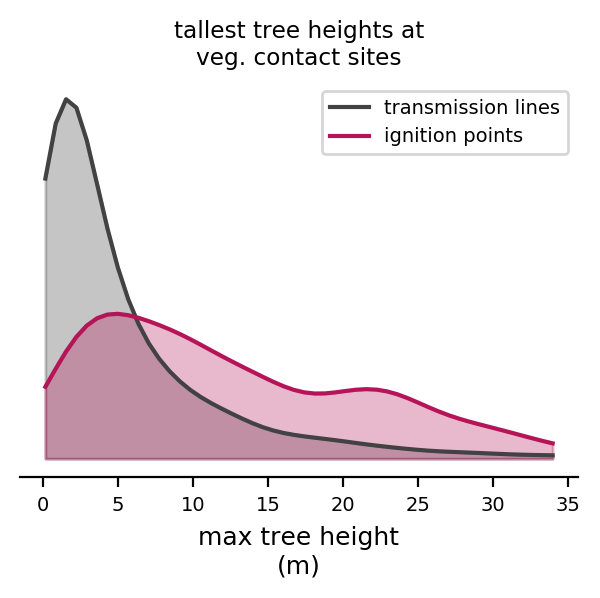

In [0]:
# set the parameters
attribute = 'max tree height' # the attribute to evaluate
data = vegetation # the failure type to understand
title = 'tallest tree heights at\nveg. contact sites' # the plot title
unit = units[attribute] # the physical unit of mapping

# create the plot (plot_dist is defined in notebook section 0.2: useful functions)
plt = plot_dist(background, data, attribute, unit, plt, title)

We see that tree heights are typically fairly low around the majority of transmission lines. This makes sense—large clearance is typically maintained along transmission lines.

We also see that the distribution of tree heights for areas that experienced vegetation contact are more uniformly distributed across height strata. The majority of veg. contact ignitions occur around trees 5m tall, and the frequency of tall trees at failure sites does not decline as fast as the frequency of tall trees across all transmission lines.

These data would suggest the probability that a vegetation contact ignition would occur is higher in areas with taller trees, and lower in areas with shorter trees. Checks out, right?

Well, what about wind speed patterns?

### 2.2 evaluating wind speed patterns where vegetation contact ignitions occurred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


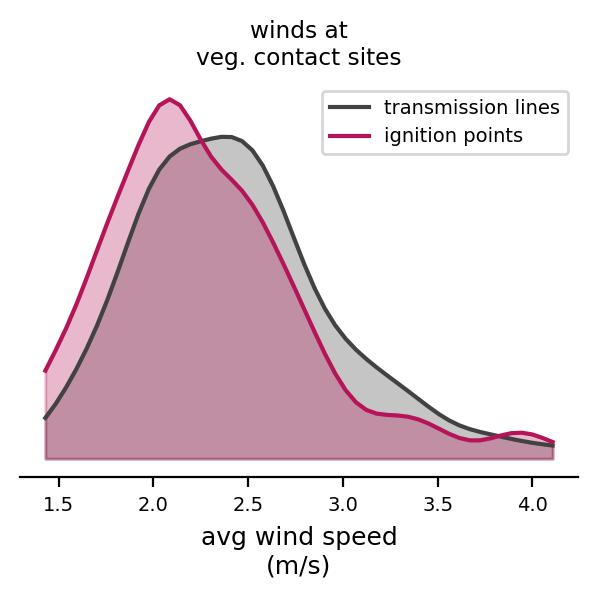

In [0]:
# set the parameters
attribute = 'avg wind speed' # the attribute to evaluate
data = vegetation # the failure type to understand
title = 'winds at\nveg. contact sites' # the plot title
unit = units[attribute] # the physical unit of mapping

# create the plot
plt = plot_dist(background, data, attribute, unit, plt, title)

It looks here that, on average, the wind speeds in areas where ignitions occurred are typically lower than the wind speeds experienced across all assets.

My first intuition is that this would suggest there's a lack of wind resillience on behalf of the trees that do fail. PG&E's Veg. team suggested that trees exposed to regular winds tend to be pretty hardy and don't fail as often, but trees in low wind environments can snap branches off more easily.

So, then we might expect to see higher maximum wind speeds in ignition sites. Is this so?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


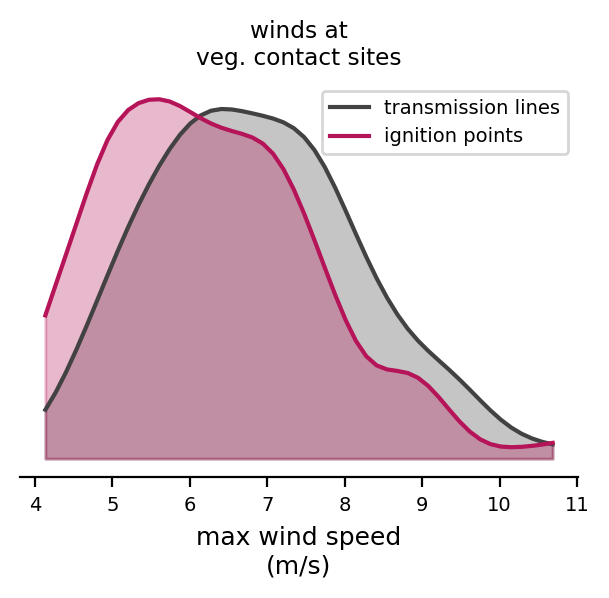

In [0]:
# set the parameters
attribute = 'max wind speed' # the attribute to evaluate
data = vegetation # the failure type to understand
title = 'winds at\nveg. contact sites' # the plot title
unit = units[attribute] # the physical unit of mapping

# create the plot
plt = plot_dist(background, data, attribute, unit, plt, title)

So the patterns we see here are pretty much the same. Lower maximum wind speeds measured over the course of the year in areas where ignitions occurred from veg. contact.

I'm not sure how much to trust these data -- they're from a large sample of wind speed measurements (once per hour over three years) and calculated as the 99th percentile of wind speeds (to try and get at extremes). However, since we're likely to be biased towards lower speeds (as winds don't typically sustain at high rates), we're unlikely to track extreme events using these data. Furthermore, these data do not include **gust speeds**, which capture short bursts of wind at a finer time scale.

So, we may want to find a way to try and quantify wind speeds at the time of the event to see how those shake out.

### 2.3 evaluating annual temperature patterns where vegetation contact ignitions occurred
Are ignitions biased towards hotter or colder locations? I might expect there to be more ignitions in warmer areas, where trees are more drought stressed or where a fire is more likely to sustain after ignition (and therefore be included in the ignition dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


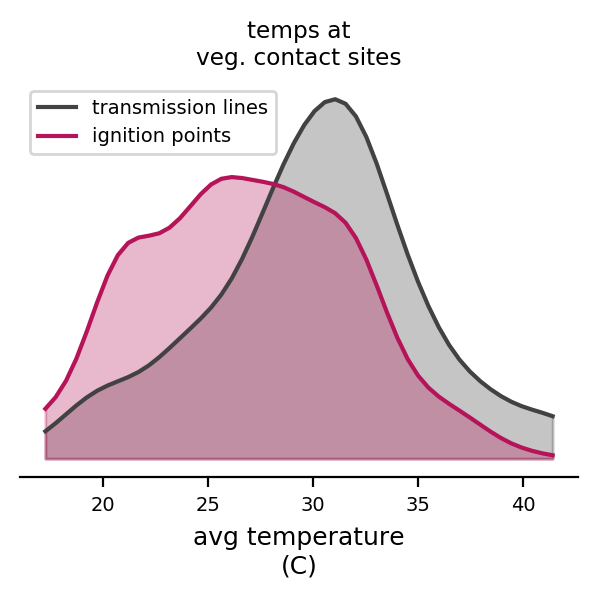

In [0]:
# set the parameters
attribute = 'avg temperature' # the attribute to evaluate
data = vegetation # the failure type to understand
title = 'temps at\nveg. contact sites' # the plot title
unit = units[attribute] # the physical unit of mapping

# create the plot
plt = plot_dist(background, data, attribute, unit, plt, title)

Contrary to expectations, it looks like the temperature patterns at ignition sites is biased towards areas with lower average annual temperatures. 

This result has a similar caveat to the wind speed exploration. We're tracking average conditions over a lot of observations -- daily temperature measurements over three years. This doesn't really capture the effects of extreme events. But it is useful to know that these ignitions occur more often in cooler landscapes.

I might suggest we look into a temperature anomaly metric. Are these ignitions just occurring in typically cooler areas that burn during anomalously warm events? If so, how should we quantify these events?

Furthermore, this may be where its important to consider where we're drawing our 'background' points from. In this case, the ignition points are biased towards lower temperatures relative to the background. But, are the conditions experienced by transmission lines representative of the conditions experienced by distribution lines? It may be that transmission lines are disproportionately located in warmer areas like the central valley or in exposed areas to maintain vegetation clearance, which increases average tempreatures.

### 2.4 evaluating annual temperature patterns where animal contact ignitions occurred
Are these temperature patterns different for ignitions started by animal contact?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


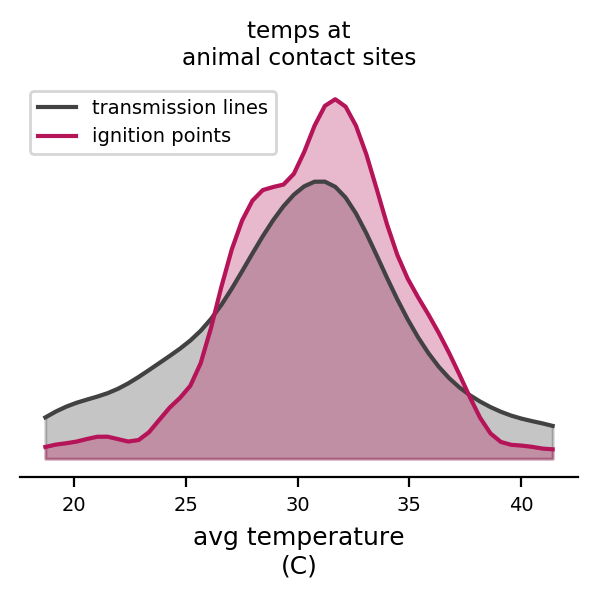

In [0]:
# set the parameters
attribute = 'avg temperature' # the attribute to evaluate
data = animal # the failure type to understand
title = 'temps at\nanimal contact sites' # the plot title
unit = units[attribute] # the physical unit of mapping

# create the plot
plt = plot_dist(background, data, attribute, unit, plt, title)

The temperature response for animal contact igntions is markedly different from the veg. contact failures. It looks like the temperature distributions are pretty well constrained to locations within a narrow temperature window -- 25 to 35 degrees C. This is probably because the animasl most likely driving contact (squirrels) are only located in fairly temperate locations (i.e. not in super cold or super hot areas). This is, coincidentally, my ideal temperature range.

### 3.0 appendix - create and save all plots
The above are just demonstrations of the existing data we have. To view all the potential distributions, you can run the script below and save the results somewhere.

The following script runs on the colab instance and save the plots to the mounted Google Drive directory. You can change this path if you like to save them to a new location.

In [0]:
# set up lists to iterate over
titles = [
    'contact_vegetation', 
    'contact_animal',
    'equipment_conductor',
    'equipment_splice'
]

datasets = [
    vegetation,
    animal,
    conductor,
    splice
]

## plot the data
for data, title in zip(datasets, titles):
    print(title)
    
    # for each attribute, plot the distributions along transmission lines and at ignitions
    for attribute in attributes:
        
        # debug
        print("plotting " + attribute)
        
        # subset the data
        bck = background[fields[attribute]].to_numpy()
        ign = data[fields[attribute]].to_numpy()
        
        # ensure no nan/nodata
        bck = bck[np.isfinite(bck)]
        ign = ign[np.isfinite(ign)]
        
        # create the figure
        plt.figure(figsize=figsize, dpi=dpi)
        density_dist([bck, ign], plot=plt, color=cols, 
                     label=labels, fill_alpha=0.35, linewidth=3)
        
        # add plot labels
        plt.title(title)
        plt.xlabel("{field}\n{units}".format(field=attribute, units=units[attribute]), fontsize=fs_xlabel)
        plt.ylabel("relative frequency", fontsize=fs_xlabel)
        plt.ylabel("", fontsize=fs_xlabel)
        
        # set frame and tick visibility
        ax = plt.axes()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #plt.yticks([0, 0.05, 0.10])
        #ax.axes.get_yaxis().set_visible(False)
        plt.tick_params(left=False, labelleft=False)
        plt.tight_layout()
        
        # save it!
        plt.savefig(plots + title + '_' + fields[attribute] + '.png', dpi=300)
        plt.close()

contact_vegetation
avg wind speed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


max wind speed
avg tempearture
max temperature
local topo. position
landscape topo. position
avg tree height
max tree height
avg tree cover
contact_animal
avg wind speed
max wind speed
avg tempearture
max temperature
local topo. position
landscape topo. position
avg tree height
max tree height
avg tree cover
equipment_conductor
avg wind speed
max wind speed
avg tempearture
max temperature
local topo. position
landscape topo. position
avg tree height
max tree height
avg tree cover
equipment_splice
avg wind speed
max wind speed
avg tempearture
max temperature
local topo. position
landscape topo. position
avg tree height
max tree height
avg tree cover
